In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import missingno as msno
from yellowbrick.style import set_palette
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.target import ClassBalance
#plt.style.use sns poster or other presentation aesthetic style(s)
plt.style.use('seaborn-talk')
# set_palette('colorblind')
from datetime import datetime

In [2]:
from sklearn.preprocessing import MinMaxScaler

from yellowbrick.cluster import InterclusterDistance
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

from sklearn.metrics import cohen_kappa_score
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassificationReport
from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pyod.models.iforest import IForest
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import EasyEnsembleClassifier

In [3]:
data = pd.read_csv('big_startup_secsees_dataset.csv')

## Filtering for US Data

In [4]:
data = data[data['country_code'] == 'USA']

In [5]:
data.shape

(37601, 14)

## Dropping rows where funding_total_usd was not reported

In [6]:
data['funding_total_usd'] = data['funding_total_usd'].replace('-',0)

In [7]:
data['funding_total_usd'] = data['funding_total_usd'].astype(float)

## Droping null Values from founded_at Column

In [8]:
data = data.dropna()

## Considering companies founded after 2009

In [9]:
data['founded_at'] = data['founded_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['first_funding_at'] = data['first_funding_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
data['last_funding_at'] = data['last_funding_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)

In [10]:
data['founded_Year'] = data['founded_at'].apply(lambda x:x.year)

In [11]:
data = data[data['founded_Year'] > 2009]

## Dropping Duplicates

In [12]:
data.drop_duplicates(keep=False, inplace=True)

In [13]:
data['final_status'] = data['status'].apply(lambda x:0 if x in ('closed') else 1 )

In [14]:
data['market'] = data['category_list'].apply(lambda x:x.split('|')[0])

## Dropping permalink, homepage_url, name, category_list column

In [15]:
data.drop(['permalink', 'homepage_url', 'name', 'category_list'], axis=1, inplace= True)

In [16]:
data

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_Year,final_status,market
1,700000.0,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04 00:00:00,2014,2014,2014,1,Application Platforms
4,0.0,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01 00:00:00,2014,2014,2010,1,Software
7,33600000.0,operating,USA,CA,SF Bay Area,Mountain View,4,2011-01-01 00:00:00,2013,2015,2011,1,Analytics
8,1150050.0,operating,USA,CA,SF Bay Area,San Francisco,3,2011-08-01 00:00:00,2011,2014,2011,1,Mobile
11,0.0,operating,USA,FL,Orlando,Orlando,1,2013-12-07 00:00:00,2014,2014,2013,1,Networking
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66346,0.0,operating,USA,CA,Ontario - Inland Empire,Redlands,1,2010-09-03 00:00:00,2011,2011,2010,1,Mobile
66350,13000000.0,ipo,USA,PA,Philadelphia,Radnor,1,2014-01-01 00:00:00,2014,2014,2014,1,Pharmaceuticals
66356,3300000.0,operating,USA,NY,New York City,New York,2,2013-01-01 00:00:00,2015,2015,2013,1,Cloud Computing
66357,2150000.0,operating,USA,NY,New York City,New York,2,2011-01-01 00:00:00,2013,2013,2011,1,Public Transportation


## Dropping city due to redundant data with region

In [17]:
data.drop('city',axis=1,inplace=True)

In [18]:
data

,funding_total_usd,status,country_code,state_code,region,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_Year,final_status,market
1,700000.0,operating,USA,DE,DE - Other,2,2014-09-04 00:00:00,2014,2014,2014,1,Application Platforms
4,0.0,operating,USA,IL,"Springfield, Illinois",1,2010-01-01 00:00:00,2014,2014,2010,1,Software
7,33600000.0,operating,USA,CA,SF Bay Area,4,2011-01-01 00:00:00,2013,2015,2011,1,Analytics
8,1150050.0,operating,USA,CA,SF Bay Area,3,2011-08-01 00:00:00,2011,2014,2011,1,Mobile
11,0.0,operating,USA,FL,Orlando,1,2013-12-07 00:00:00,2014,2014,2013,1,Networking
...,...,...,...,...,...,...,...,...,...,...,...,...
66346,0.0,operating,USA,CA,Ontario - Inland Empire,1,2010-09-03 00:00:00,2011,2011,2010,1,Mobile
66350,13000000.0,ipo,USA,PA,Philadelphia,1,2014-01-01 00:00:00,2014,2014,2014,1,Pharmaceuticals
66356,3300000.0,operating,USA,NY,New York City,2,2013-01-01 00:00:00,2015,2015,2013,1,Cloud Computing
66357,2150000.0,operating,USA,NY,New York City,2,2011-01-01 00:00:00,2013,2013,2011,1,Public Transportation


## Creating new columns

In [19]:
data['funding_diff'] = (data['last_funding_at'] - data['first_funding_at'])
data['years_operating'] = (2023 - data['founded_Year'])

In [20]:
data

,funding_total_usd,status,country_code,state_code,region,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_Year,final_status,market,funding_diff,years_operating
1,700000.0,operating,USA,DE,DE - Other,2,2014-09-04 00:00:00,2014,2014,2014,1,Application Platforms,0,9
4,0.0,operating,USA,IL,"Springfield, Illinois",1,2010-01-01 00:00:00,2014,2014,2010,1,Software,0,13
7,33600000.0,operating,USA,CA,SF Bay Area,4,2011-01-01 00:00:00,2013,2015,2011,1,Analytics,2,12
8,1150050.0,operating,USA,CA,SF Bay Area,3,2011-08-01 00:00:00,2011,2014,2011,1,Mobile,3,12
11,0.0,operating,USA,FL,Orlando,1,2013-12-07 00:00:00,2014,2014,2013,1,Networking,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66346,0.0,operating,USA,CA,Ontario - Inland Empire,1,2010-09-03 00:00:00,2011,2011,2010,1,Mobile,0,13
66350,13000000.0,ipo,USA,PA,Philadelphia,1,2014-01-01 00:00:00,2014,2014,2014,1,Pharmaceuticals,0,9
66356,3300000.0,operating,USA,NY,New York City,2,2013-01-01 00:00:00,2015,2015,2013,1,Cloud Computing,0,10
66357,2150000.0,operating,USA,NY,New York City,2,2011-01-01 00:00:00,2013,2013,2011,1,Public Transportation,0,12


In [21]:
date_cols = ['first_funding_at', 'last_funding_at']
data = pd.concat([data, pd.get_dummies(data[date_cols].astype(str))], axis=1)
data = data.drop(date_cols,axis=1)

## Performing ONE HOT Encoding

In [22]:
data = pd.concat([data, pd.get_dummies(data['market'])], axis=1)
data.drop('market',axis=1,inplace=True)
data = pd.concat([data, pd.get_dummies(data['country_code'])], axis=1)
data.drop('country_code',axis=1,inplace=True)
data = pd.concat([data, pd.get_dummies(data['region'])], axis=1)
data.drop('region',axis=1,inplace=True)

In [23]:
data

,funding_total_usd,status,state_code,funding_rounds,founded_at,founded_Year,final_status,funding_diff,years_operating,first_funding_at_1014,...,WI - Other,WV - Other,WY - Other,"Washington, D.C.",Wichita,"Wilmington - Cape Fear, North Carolina","Wilmington, Delaware",Winston-Salem,Worcester,Youngstown
1,700000.0,operating,DE,2,2014-09-04 00:00:00,2014,1,0,9,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,operating,IL,1,2010-01-01 00:00:00,2010,1,0,13,0,...,0,0,0,0,0,0,0,0,0,0
7,33600000.0,operating,CA,4,2011-01-01 00:00:00,2011,1,2,12,0,...,0,0,0,0,0,0,0,0,0,0
8,1150050.0,operating,CA,3,2011-08-01 00:00:00,2011,1,3,12,0,...,0,0,0,0,0,0,0,0,0,0
11,0.0,operating,FL,1,2013-12-07 00:00:00,2013,1,0,10,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66346,0.0,operating,CA,1,2010-09-03 00:00:00,2010,1,0,13,0,...,0,0,0,0,0,0,0,0,0,0
66350,13000000.0,ipo,PA,1,2014-01-01 00:00:00,2014,1,0,9,0,...,0,0,0,0,0,0,0,0,0,0
66356,3300000.0,operating,NY,2,2013-01-01 00:00:00,2013,1,0,10,0,...,0,0,0,0,0,0,0,0,0,0
66357,2150000.0,operating,NY,2,2011-01-01 00:00:00,2011,1,0,12,0,...,0,0,0,0,0,0,0,0,0,0


## creating new columns

In [24]:
data['per_round'] = data['funding_total_usd'] / data['funding_rounds']

## dropping state_code, founded_year, founded_at and status column

In [25]:
data.drop(['state_code','founded_Year','founded_at','status'], inplace=True, axis=1)

## Setting X and Y

In [26]:
X = data.drop('final_status',axis=1)
y = data['final_status']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [28]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

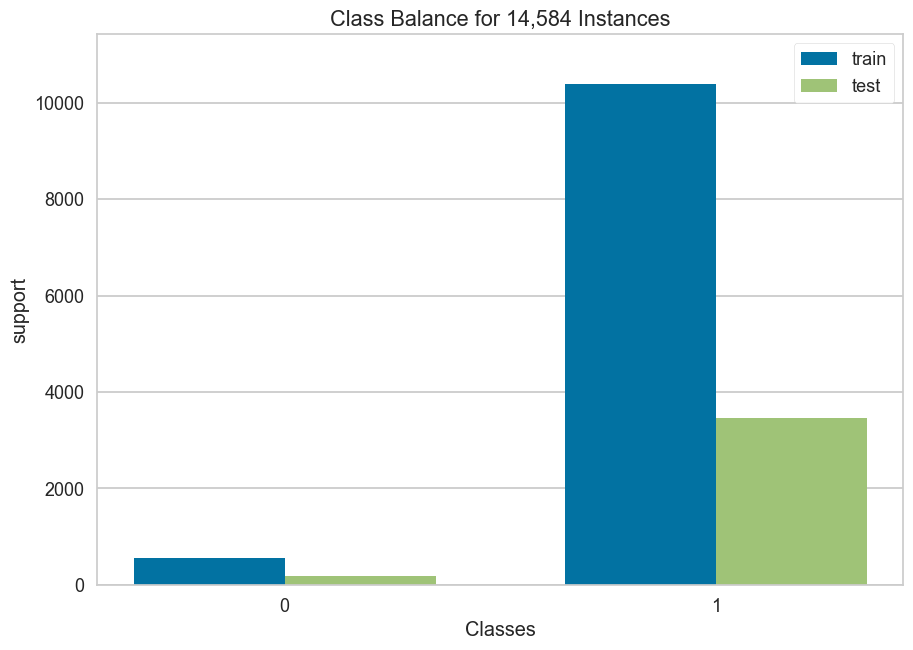

<AxesSubplot:title={'center':'Class Balance for 14,584 Instances'}, xlabel='Classes', ylabel='support'>

In [29]:
visualizer = ClassBalance(labels=[0, 1])

visualizer.fit(y_train,y_test)
visualizer.ax.set_xlabel("Classes")
visualizer.ax.set_ylabel("Amount of Occurrences of Class")
visualizer.show()

## Modelling

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

from sklearn import metrics

from sklearn.linear_model import LogisticRegression

In [31]:
def classify(clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    '''Passed a classifier and appropriate test-train split, displays a classification report, class prediction error, 
    and several metrics- f1 weighted, micro, macro and Cohen kappa- to show results. '''
    clf.fit(X_train, y_train)
    
    best_params = clf.best_params_
    best_model = clf.best_estimator_

    y_pred = best_model.predict(X_test)
    
    fig = plt.figure(linewidth=10, edgecolor="#04253a")
    clf_rep = ClassificationReport(clf, classes=[0,1], support=True)
    clf_rep.fit(X_train, y_train)
    clf_rep.score(X_test, y_test)      
    clf_rep.show() 
    
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    type_1_error = fp
    type_2_error = fn
    sensitivity = recall_score(y_test, y_pred)
    
    table_list = []
    table_list.append(accuracy)
    table_list.append(specificity)
    table_list.append(type_1_error)
    table_list.append(type_2_error)
    table_list.append(sensitivity)
    
#     print('Accuracy - ',accuracy)
#     print('Specificity - ',specificity)
#     print('Sensitivity - ', sensitivity)
#     print('Type I Error - ', type_1_error)
#     print('Type II Error - ', type_2_error)
    
    auc = metrics.roc_auc_score(y_test, y_pred)

    false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

    plt.figure(figsize=(10, 8), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'g')
    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    print('=============================================================================')

    from yellowbrick.classifier import ClassPredictionError
    fig = plt.figure(linewidth=10, edgecolor="#04253a")
    pred_error = ClassPredictionError(clf, classes=[0,1])
    pred_error.fit(X_train, y_train)
    pred_error.score(X_test, y_test)

    pred_error.show()
    print(f"^^^ Classification Report for {clf.__class__.__name__} ^^^")
    print(f"F1 weighted score is {f1_score(y_test, y_pred, average='weighted')}")    
    print(f"F1 micro score is {f1_score(y_test, y_pred, average='micro')}")      
    print(f"F1 macro score is {f1_score(y_test, y_pred, average='macro')}")
    print(f"Cohen kappa score is {cohen_kappa_score(y_test, y_pred)}") 
    plt.tight_layout()

    return table_list

In [32]:
def classify_multiple(clfs, X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test, kind=None):
    '''When passed multiple classifiers and a test-train split, runs classify() to run each together. Optional
    kind parameter helps to print out what sort of classifiers are being used.'''
    if kind == "balanced":
        print("Balanced Classifiers Report")
    elif kind == "boost":
        print("Boosting Classifiers Report")
    else:
        print("Base Classifiers Report")
    table = []
    for clf in clfs:
        
        table_list = classify(clf[0],X_train=X_tr, y_train=y_tr, X_test=X_te, y_test=y_te)
        table.append(table_list+[clf[1]])
    return table

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [34]:
classifiers1 = [[GridSearchCV(estimator=LogisticRegression(), param_grid={'C': [0.1, 1.0, 10.0],'penalty': ['l1', 'l2'],'solver': ['liblinear', 'saga']}, cv=5),
'Logistic Regression'],
               [GridSearchCV(estimator=DecisionTreeClassifier(), param_grid={
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}, cv=5),'Decision Tree'],
               [GridSearchCV(estimator=RandomForestClassifier(), param_grid={
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}, cv=5),'Random Forest'],
               [GridSearchCV(XGBClassifier(), param_grid={'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],'n_estimators': [100, 500, 1000]}, cv=5),'XGBoost']]

In [35]:
# #naive, simple tree based models
# classifiers=[ 
#     [DecisionTreeClassifier(max_depth=5),'Decision Tree'],
#     [RandomForestClassifier(random_state=0),'Random Forest'],
#     [LogisticRegression(random_state=0), 'Logistic Regression'],
   
# ]

# #  [GridSearchCV(XGBClassifier(random_state=0), param_grid={
# #         'n_estimators': [100,200],
# #         'learning_rate': [0.001,0.01,0.1,0.2,0.5]
# #     }),'XGBoost']

# #classifiers using class_weight = 'balanced'
# balanced_classifiers=[RandomForestClassifier(random_state=0, class_weight='balanced')]

# #boosted trees
# boost_clf=[GridSearchCV(XGBClassifier(), param_grid={'learning_rate': [0.1, 0.01, 0.001],
#     'max_depth': [3, 5, 7],'n_estimators': [100, 500, 1000]}, cv=5),'XGBoost']

## ADASYN

In [36]:
from imblearn.over_sampling import ADASYN

print('Original class distribution: \n')
print(y.value_counts())
ada = ADASYN(random_state=0)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train) 
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_ada).value_counts()) 

Original class distribution: 

1    13849
0      735
Name: final_status, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    10387
0    10385
Name: final_status, dtype: int64


Base Classifiers Report


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

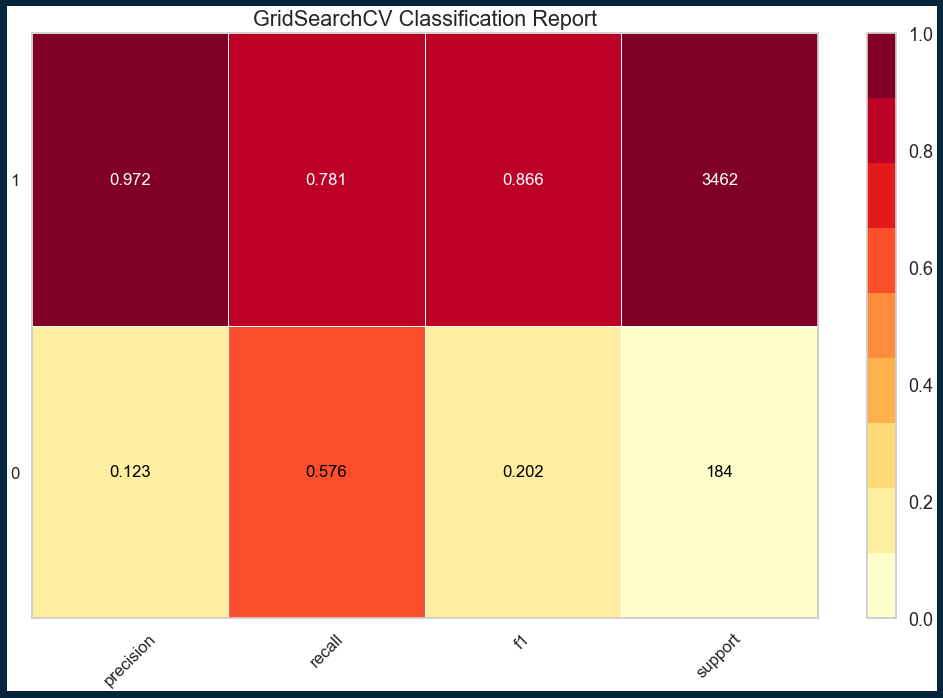

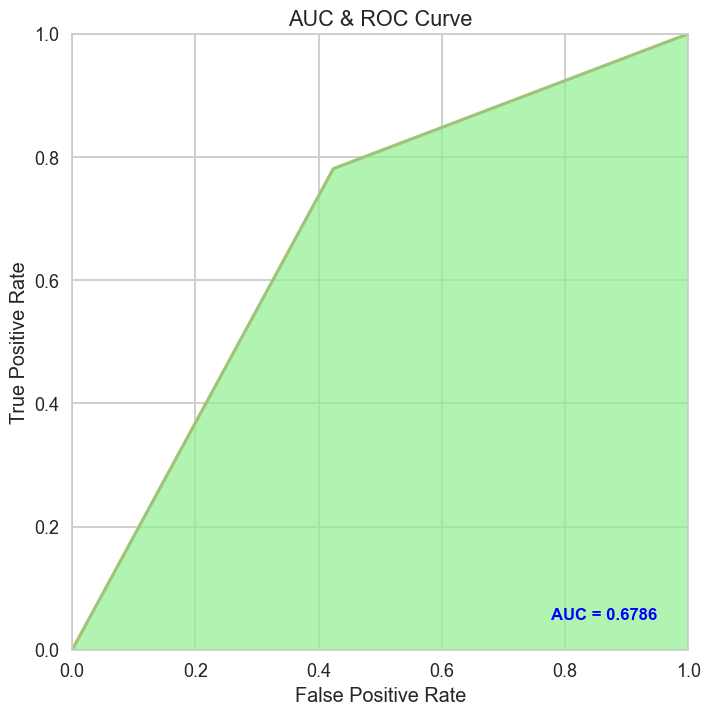

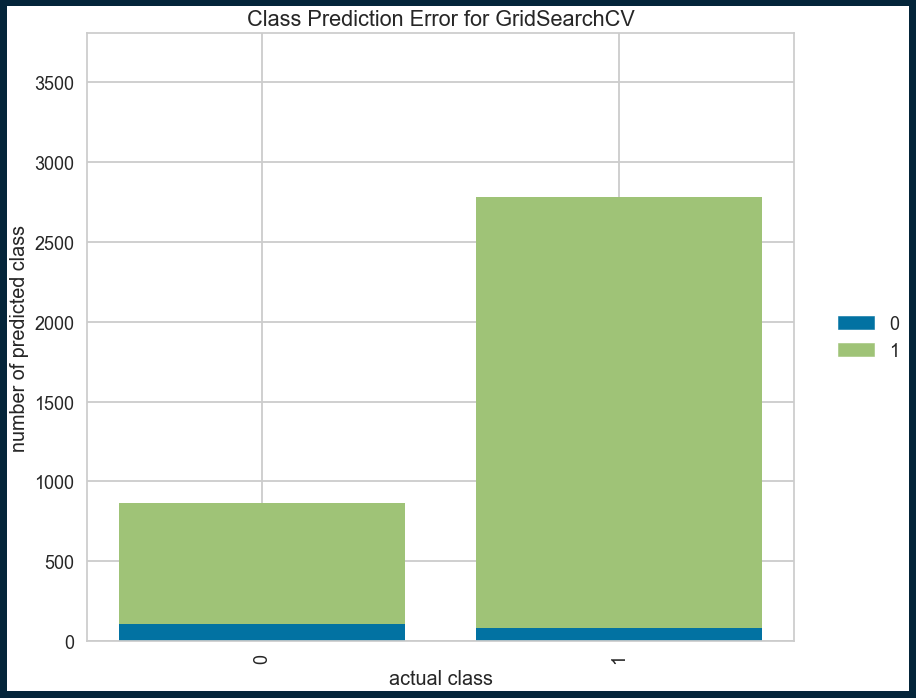

^^^ Classification Report for GridSearchCV ^^^
F1 weighted score is 0.8326108811927133
F1 micro score is 0.7707076247942951
F1 macro score is 0.5342007716721029
Cohen kappa score is 0.1298865904513088


<Figure size 1040x715 with 0 Axes>

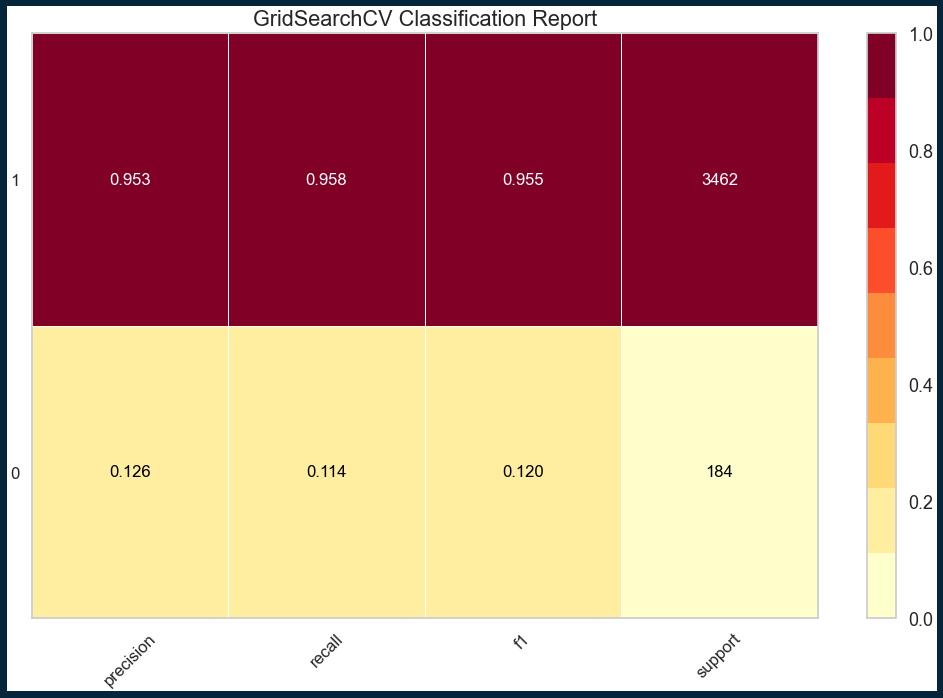

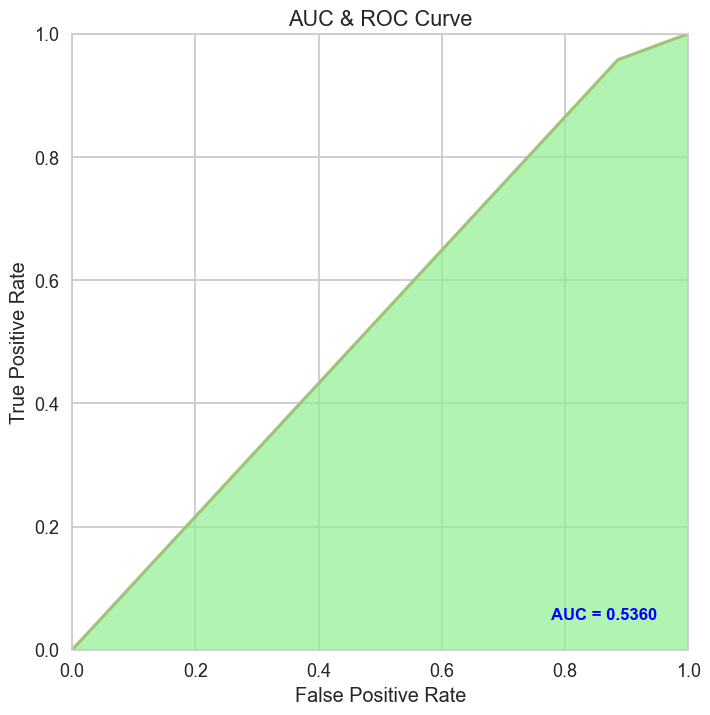

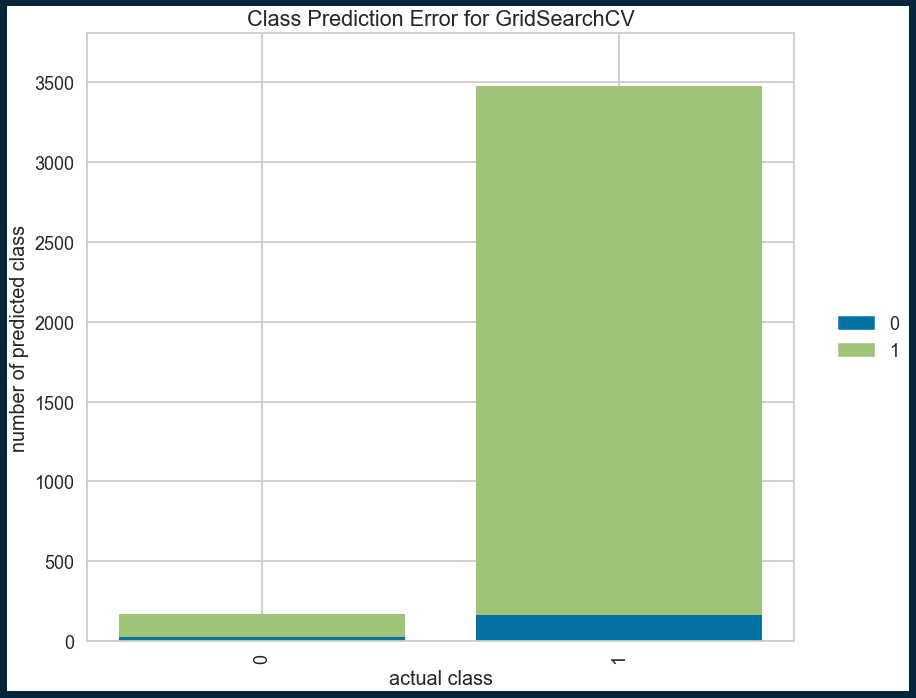

^^^ Classification Report for GridSearchCV ^^^
F1 weighted score is 0.9133010141813833
F1 micro score is 0.9152495885902359
F1 macro score is 0.5375700193449797
Cohen kappa score is 0.07524973528470236


<Figure size 1040x715 with 0 Axes>

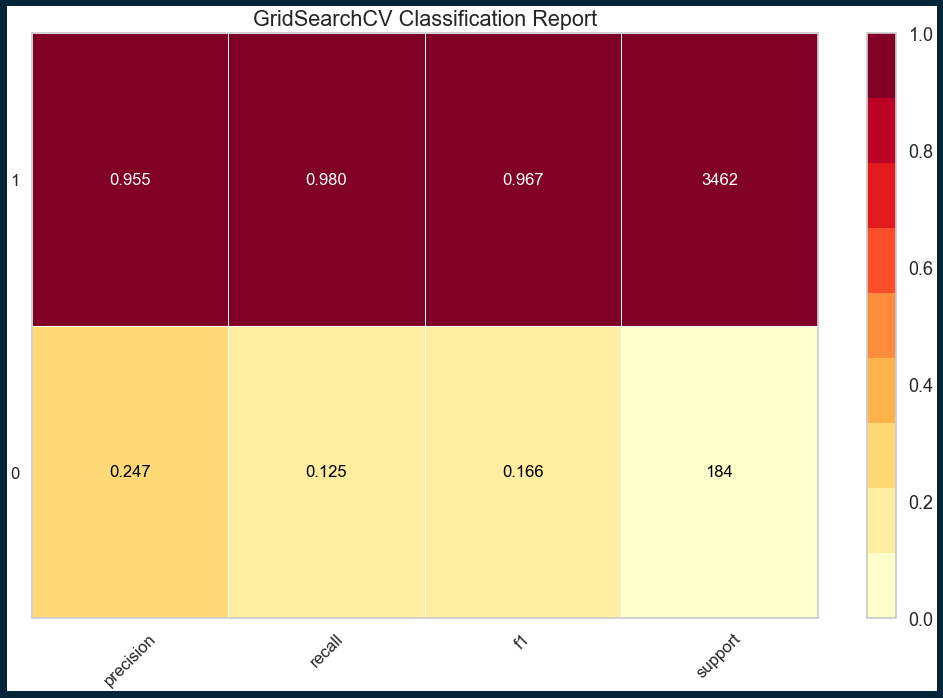

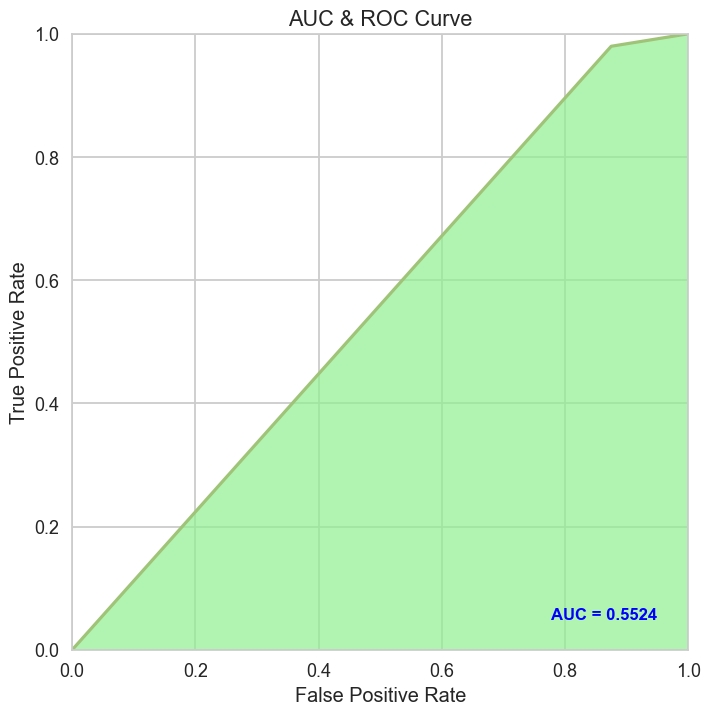

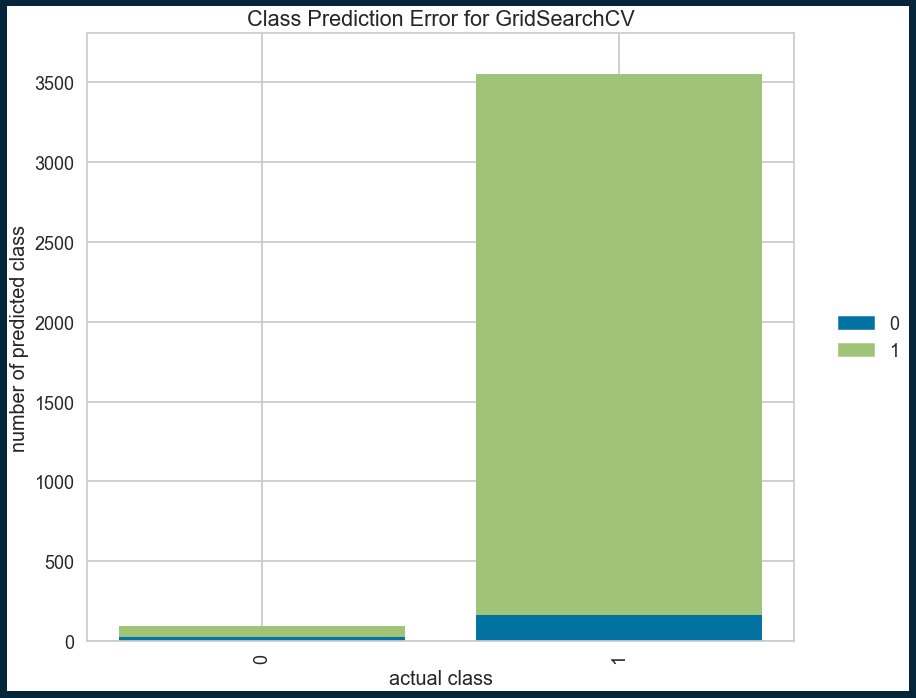

^^^ Classification Report for GridSearchCV ^^^
F1 weighted score is 0.9266468036364786
F1 micro score is 0.9366428963247395
F1 macro score is 0.5665677725142872
Cohen kappa score is 0.1368141204733334


<Figure size 1040x715 with 0 Axes>

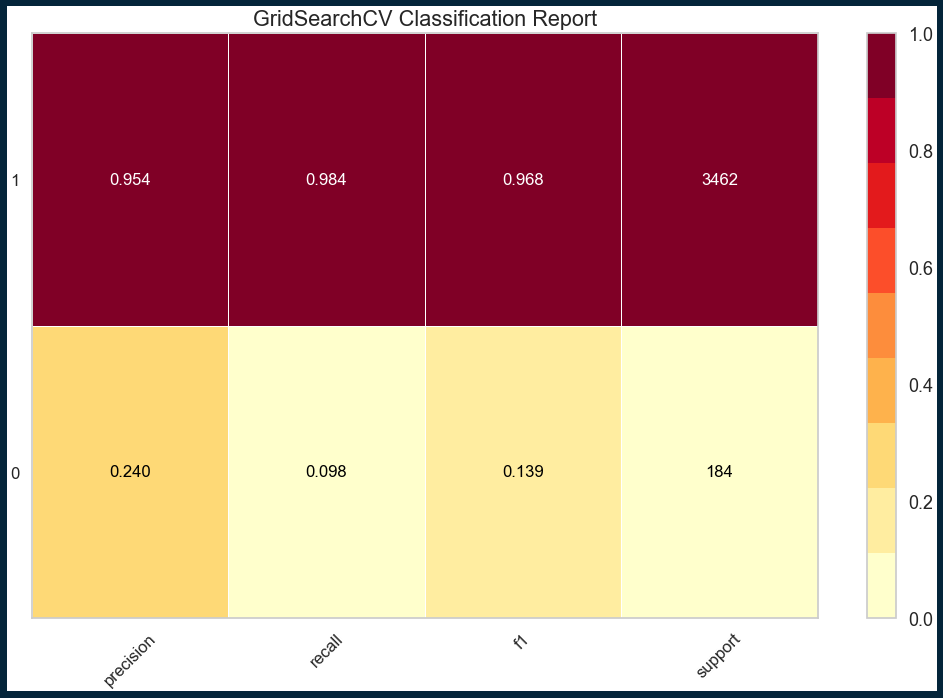

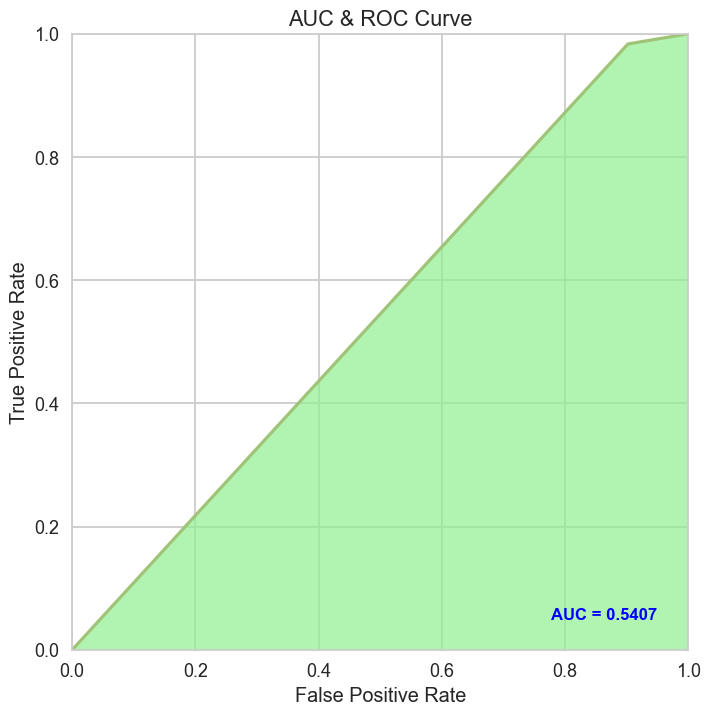

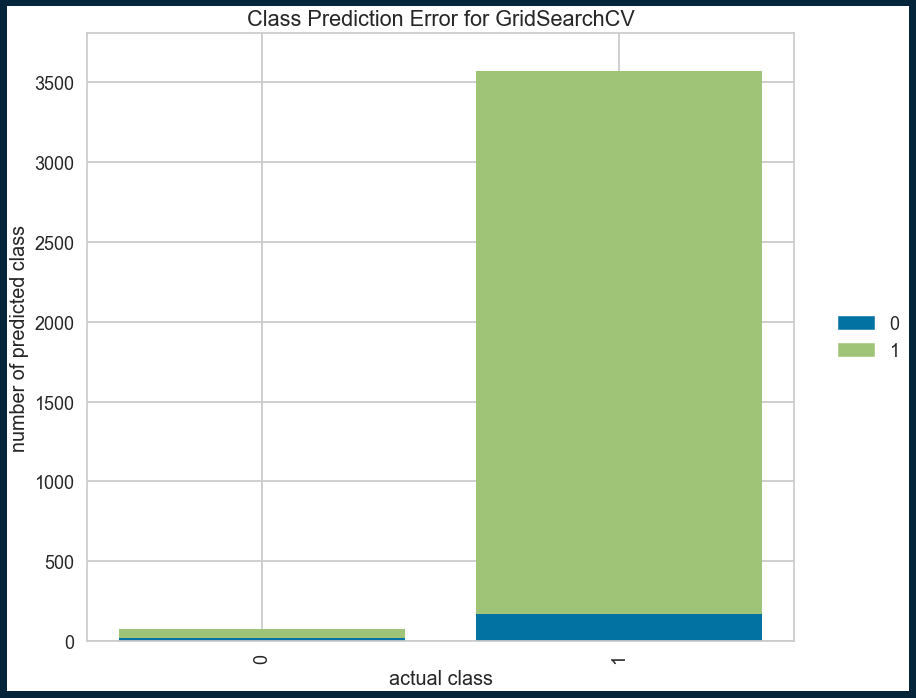

^^^ Classification Report for GridSearchCV ^^^
F1 weighted score is 0.9264408549797647
F1 micro score is 0.9388370817334065
F1 macro score is 0.5536442375629067
Cohen kappa score is 0.11307343402631576


<Figure size 1040x715 with 0 Axes>

In [37]:
qq = classify_multiple(classifiers1, X_tr=X_train_ada, X_te=X_test, y_tr=y_train_ada, y_te=y_test)

In [38]:
qq_dataframe = pd.DataFrame(qq)
qq_dataframe.columns = ['Accuracy', 'Specificity','Type I Error', 'Type II Error','Sensitivity', 'Model']

In [39]:
qq_dataframe

,Accuracy,Specificity,Type I Error,Type II Error,Sensitivity,Model
0,0.770708,0.576087,78,758,0.781051,Logistic Regression
1,0.915250,0.114130,163,146,0.957828,Decision Tree
2,0.936643,0.125000,161,70,0.979780,Random Forest
3,0.938837,0.097826,166,57,0.983536,XGBoost


In [ ]:
qq = classify_multiple(classifiers, X_tr=X_train_ada, X_te=X_test, y_tr=y_train_ada, y_te=y_test)

In [ ]:
qq_dataframe = pd.DataFrame(qq)
qq_dataframe.columns = ['Accuracy', 'Specificity','Type I Error', 'Type II Error','Sensitivity', 'Model']

In [ ]:
qq_dataframe

In [ ]:
classify_multiple(boost_clf, X_tr=X_train_ada, X_te=X_test, y_tr=y_train_ada, y_te=y_test, kind="boost")